In [1]:
library(reticulate)
sagemaker <- import('sagemaker')

In [2]:
role_arn <- sagemaker$get_execution_role()

In [3]:
session <- sagemaker$Session()
bucket <- session$default_bucket()
prefix <- ''

In [4]:
library(readr)
data_file <- 's3://partly-cloudy-common-area/hourly_issr_summary.csv'
mydata <- read_csv(file = sagemaker$s3$S3Downloader$read_file(data_file,
                                                              sagemaker_session= session),
                   col_names = TRUE)

In [5]:
df <- as.data.frame(mydata)

In [6]:
head(df)

,index,dateTime,iSSRs,floor,ceiling
,<dbl>,<dttm>,<dbl>,<dbl>,<dbl>
1,7900,2020-06-01 00:00:00,7406,23564.34,41293.3
2,7205,2020-06-01 01:00:00,7250,23564.34,41293.3
3,1910,2020-06-01 02:00:00,6401,23564.34,41293.3
4,8435,2020-06-01 03:00:00,6448,23564.34,41293.3
5,3739,2020-06-01 04:00:00,7185,23564.34,41293.3
6,502,2020-06-01 05:00:00,7429,23564.34,41293.3


Sources:

http://r-statistics.co/Top50-Ggplot2-Visualizations-MasterList-R-Code.html#Bar%20Chart

http://rstudio-pubs-static.s3.amazonaws.com/392033_47b565c44b8246fca23a255bc59beabd.html


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




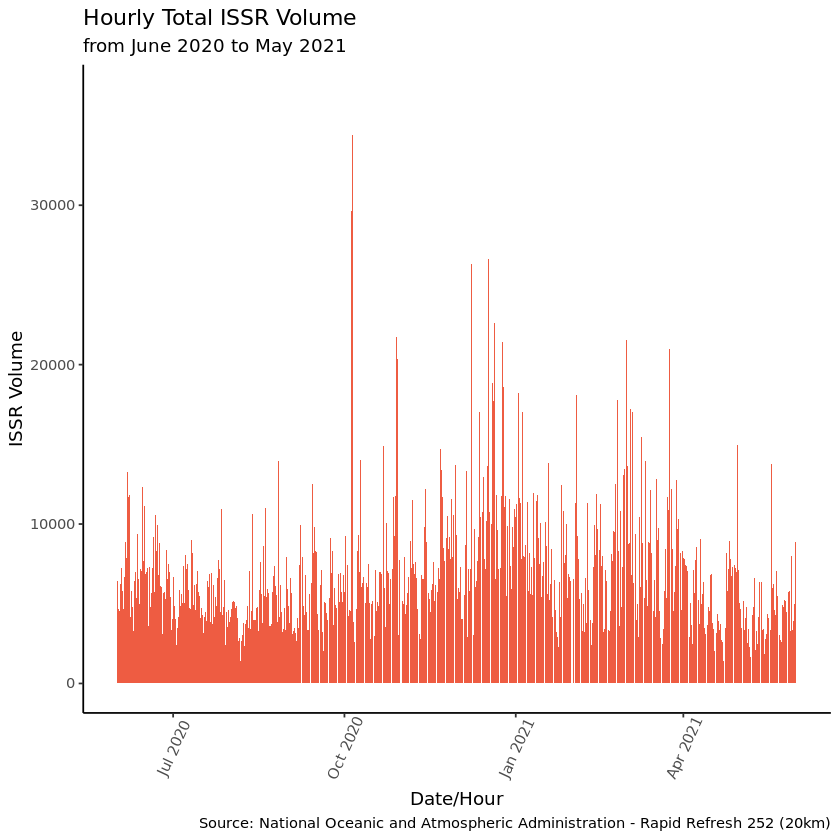

In [7]:
# plot
library(ggplot2)
library(dplyr)
theme_set(theme_classic())

# Plot
g <- ggplot(df, aes(dateTime, iSSRs))
g + geom_col(fill= "tomato2") + 
    labs(title= "Hourly Total ISSR Volume",
         subtitle= "from June 2020 to May 2021",
         caption= "Source: National Oceanic and Atmospheric Administration - Rapid Refresh 252 (20km)",
         x= "Date/Hour", 
         y= "ISSR Volume") +
theme(axis.text.x = element_text(angle=65, vjust=0.6))

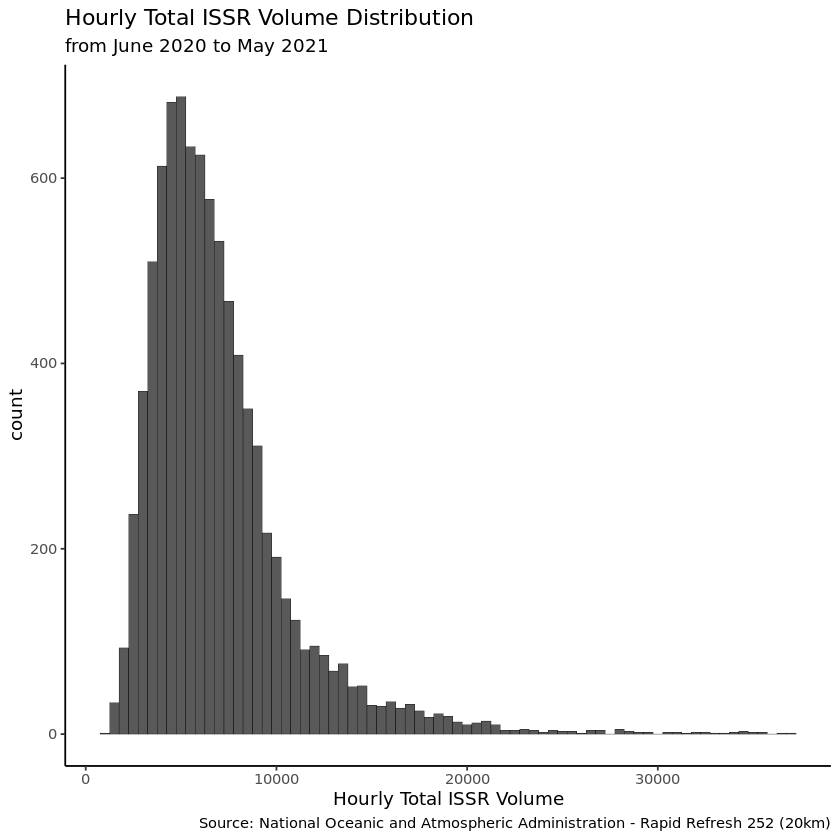

In [8]:
g <- ggplot(df, aes(iSSRs)) + scale_fill_brewer(palette= "Spectral")
g + geom_histogram(#aes(fill=class), 
                   binwidth = 500, 
                   col= "black", 
                   size= .1) +  # change binwidth
  labs(title="Hourly Total ISSR Volume Distribution", 
       subtitle="from June 2020 to May 2021",
       x= "Hourly Total ISSR Volume", 
       caption= "Source: National Oceanic and Atmospheric Administration - Rapid Refresh 252 (20km)")  

In [9]:
library(lubridate)
df$mon <- month(df$dateTime, label= TRUE)

Warning message:
“Your system is mis-configured: ‘/etc/localtime’ is not a symlink”
Warning message:
“It is strongly recommended to set envionment variable TZ to ‘Etc/UCT’ (or equivalent)”

Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




In [10]:
head(df)

,index,dateTime,iSSRs,floor,ceiling,mon
,<dbl>,<dttm>,<dbl>,<dbl>,<dbl>,<ord>
1,7900,2020-06-01 00:00:00,7406,23564.34,41293.3,Jun
2,7205,2020-06-01 01:00:00,7250,23564.34,41293.3,Jun
3,1910,2020-06-01 02:00:00,6401,23564.34,41293.3,Jun
4,8435,2020-06-01 03:00:00,6448,23564.34,41293.3,Jun
5,3739,2020-06-01 04:00:00,7185,23564.34,41293.3,Jun
6,502,2020-06-01 05:00:00,7429,23564.34,41293.3,Jun


In [11]:
month_total <- df %>% group_by(mon) %>% summarize(monthlyiSSRs = sum(iSSRs, na.rm= TRUE))

In [12]:
month_total

mon,monthlyiSSRs
<ord>,<dbl>
Jan,6427921
Feb,5121588
Mar,6287976
Apr,3948918
May,3403485
Jun,4917631
Jul,4075105
Aug,3827339
Sep,4041602


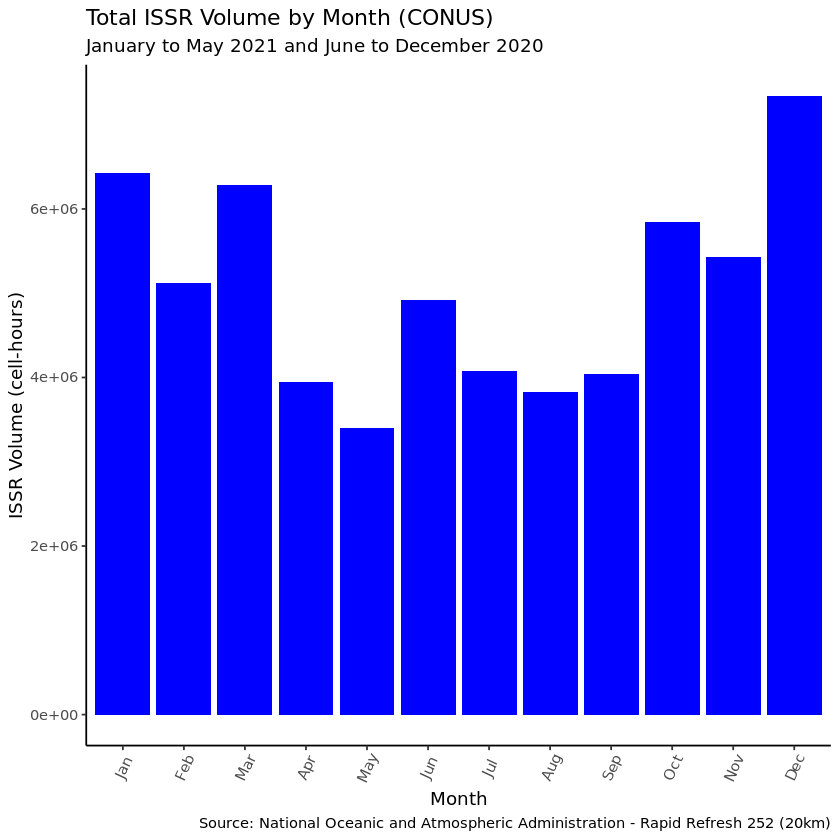

In [43]:
# Plot
g <- ggplot(month_total, aes(mon, monthlyiSSRs))
g + geom_col(fill= "blue") + 
    labs(title= "Total ISSR Volume by Month (CONUS)",
         subtitle= "January to May 2021 and June to December 2020",
         caption= "Source: National Oceanic and Atmospheric Administration - Rapid Refresh 252 (20km)",
         x= "Month", 
         y= "ISSR Volume (cell-hours)") +
theme(axis.text.x = element_text(angle=65, vjust=0.6))

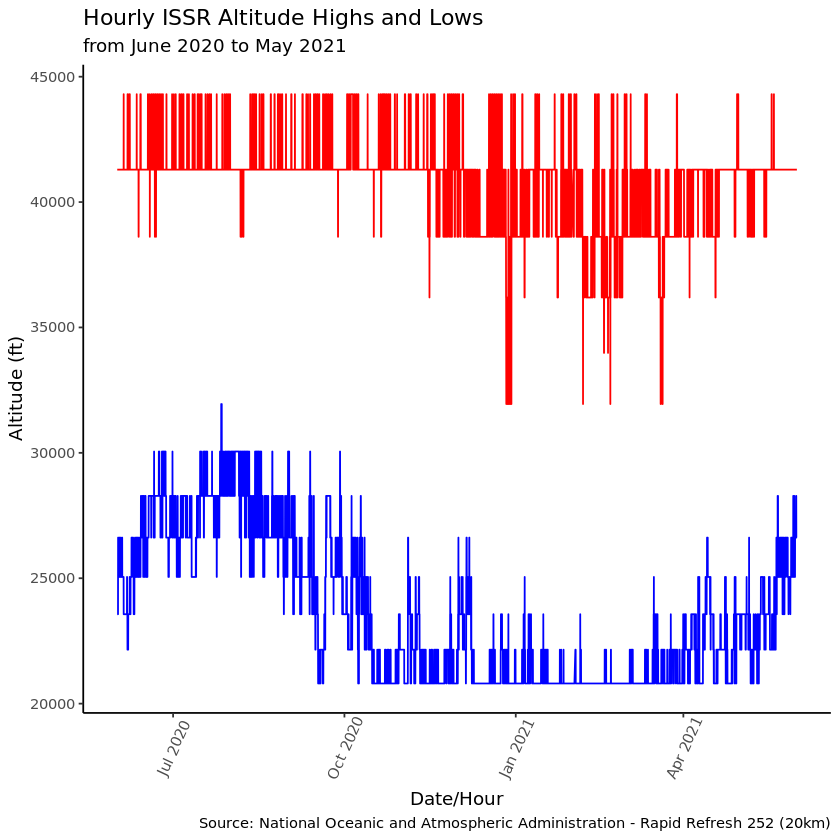

In [14]:
# Allow Default X Axis Labels
ggplot(df, aes(x= dateTime)) + 
  geom_line(aes(y= floor), color= 'blue') + geom_line(aes(y= ceiling), color= 'red') + 
  labs(title= "Hourly ISSR Altitude Highs and Lows", 
       subtitle= "from June 2020 to May 2021", 
       caption= "Source: National Oceanic and Atmospheric Administration - Rapid Refresh 252 (20km)",
       x= "Date/Hour",
       y= "Altitude (ft)") +
theme(axis.text.x = element_text(angle= 65, vjust= 0.6))

In [15]:
df_copy <- df

In [16]:
df_copy$dateTime_lag6 = df_copy$dateTime - hours(6)
df_copy$dateTime_lag12 = df_copy$dateTime - hours(12)
df_copy$dateTime_lag24 = df_copy$dateTime - hours(24)

In [17]:
df_join <- df_copy %>% inner_join(df, c('dateTime_lag6' = 'dateTime'), suffix= c('', '_6'))
df_join <- df_join %>% inner_join(df, c('dateTime_lag12' = 'dateTime'), suffix= c('', '_12'))
df_join <- df_join %>% inner_join(df, c('dateTime_lag24' = 'dateTime'), suffix= c('', '_24'))

df_join$volChange_6 <- (df_join$iSSRs - df_join$iSSRs_6)/df_join$iSSRs_6
df_join$volChange_12 <- (df_join$iSSRs - df_join$iSSRs_12)/df_join$iSSRs_12
df_join$volChange_24 <- (df_join$iSSRs - df_join$iSSRs_24)/df_join$iSSRs_24

In [18]:
head(df_join)

,index,dateTime,iSSRs,floor,ceiling,mon,dateTime_lag6,dateTime_lag12,dateTime_lag24,index_6,⋯,ceiling_12,mon_12,index_24,iSSRs_24,floor_24,ceiling_24,mon_24,volChange_6,volChange_12,volChange_24
,<dbl>,<dttm>,<dbl>,<dbl>,<dbl>,<ord>,<dttm>,<dttm>,<dttm>,<dbl>,⋯,<dbl>,<ord>,<dbl>,<dbl>,<dbl>,<dbl>,<ord>,<dbl>,<dbl>,<dbl>
1,1220,2020-06-02 00:00:00,7638,25051.00,41293.3,Jun,2020-06-01 18:00:00,2020-06-01 12:00:00,2020-06-01 00:00:00,6154,⋯,41293.3,Jun,7900,7406,23564.34,41293.3,Jun,0.48686004,-0.085926281,0.03132595
2,5781,2020-06-02 01:00:00,6599,25051.00,41293.3,Jun,2020-06-01 19:00:00,2020-06-01 13:00:00,2020-06-01 01:00:00,8372,⋯,41293.3,Jun,7205,7250,23564.34,41293.3,Jun,0.22955096,-0.239045203,-0.08979310
3,6263,2020-06-02 02:00:00,5839,25051.00,41293.3,Jun,2020-06-01 20:00:00,2020-06-01 14:00:00,2020-06-01 02:00:00,5962,⋯,41293.3,Jun,1910,6401,23564.34,41293.3,Jun,-0.01600944,-0.353806994,-0.08779878
4,3608,2020-06-02 03:00:00,6003,25051.00,41293.3,Jun,2020-06-01 21:00:00,2020-06-01 15:00:00,2020-06-01 03:00:00,1623,⋯,41293.3,Jun,8435,6448,23564.34,41293.3,Jun,-0.17597804,-0.279351741,-0.06901365
5,8093,2020-06-02 04:00:00,5409,25051.00,41293.3,Jun,2020-06-01 22:00:00,2020-06-01 16:00:00,2020-06-01 04:00:00,5730,⋯,41293.3,Jun,3739,7185,23564.34,41293.3,Jun,-0.29099489,0.158988644,-0.24718163
6,3089,2020-06-02 05:00:00,4538,26620.21,41293.3,Jun,2020-06-01 23:00:00,2020-06-01 17:00:00,2020-06-01 05:00:00,3159,⋯,41293.3,Jun,502,7429,23564.34,41293.3,Jun,-0.41976729,0.002872928,-0.38915063


In [19]:
sapply(df_join[,25:27], mean)

volChange_6 volChange_12 volChange_24 
  0.09720805   0.11095886   0.10880701

In [20]:
sapply(df_join[,25:27], sd)

volChange_6 volChange_12 volChange_24 
   0.4857126    0.5520839    0.5639855

ggplot(df_join, aes(x= dateTime)) + 
  geom_line(aes(y= volChange_6), color= 'black') + geom_line(aes(y= volChange_12), color= 'gray') + geom_line(aes(y= volChange_24), color= 'gray') +
  labs(title= "Hourly ISSR Volume Change", 
       subtitle= "from June 2020 to May 2021", 
       caption= "Source: National Oceanic and Atmospheric Administration - Rapid Refresh 252 (20km)",
       x= "Date/Hour",
       y= "Volume Change Rate (1.0 = 100% increase)") +
theme(axis.text.x = element_text(angle= 65, vjust= 0.6))

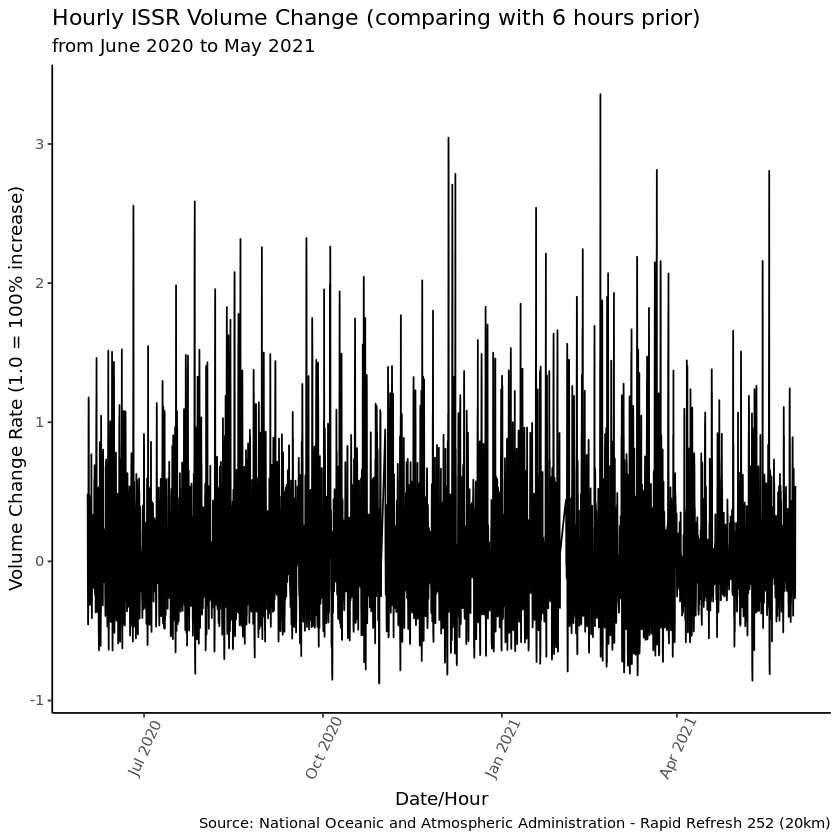

In [21]:
ggplot(df_join, aes(x= dateTime)) + 
  geom_line(aes(y= volChange_6), color= 'black') +
  labs(title= "Hourly ISSR Volume Change (comparing with 6 hours prior)", 
       subtitle= "from June 2020 to May 2021", 
       caption= "Source: National Oceanic and Atmospheric Administration - Rapid Refresh 252 (20km)",
       x= "Date/Hour",
       y= "Volume Change Rate (1.0 = 100% increase)") +
theme(axis.text.x = element_text(angle= 65, vjust= 0.6))

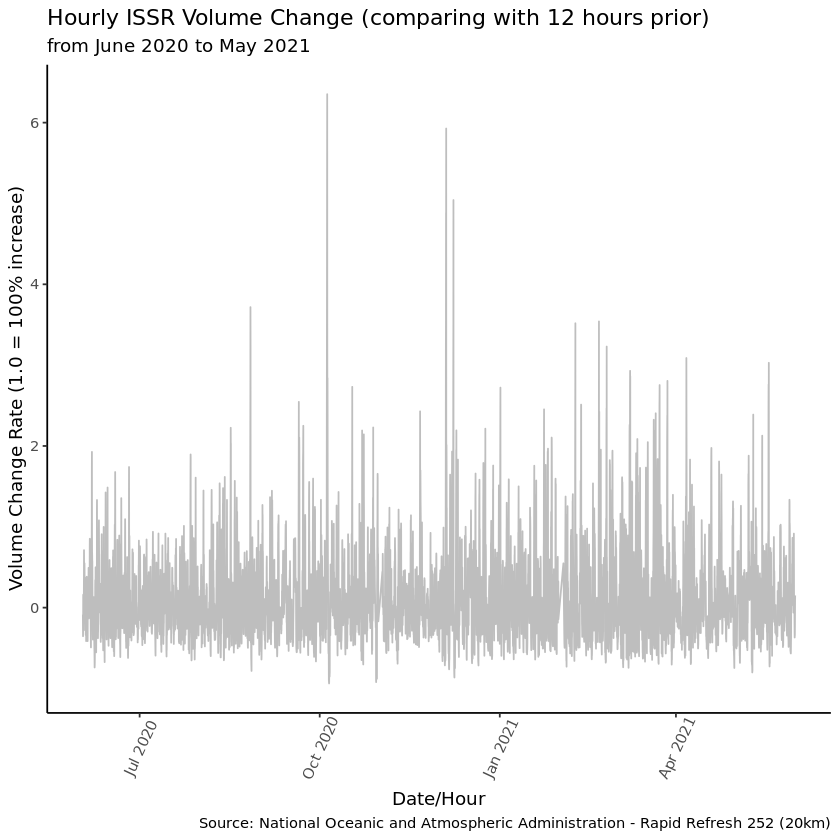

In [22]:
ggplot(df_join, aes(x= dateTime)) + 
  geom_line(aes(y= volChange_12), color= 'gray') +
  labs(title= "Hourly ISSR Volume Change (comparing with 12 hours prior)", 
       subtitle= "from June 2020 to May 2021", 
       caption= "Source: National Oceanic and Atmospheric Administration - Rapid Refresh 252 (20km)",
       x= "Date/Hour",
       y= "Volume Change Rate (1.0 = 100% increase)") +
theme(axis.text.x = element_text(angle= 65, vjust= 0.6))

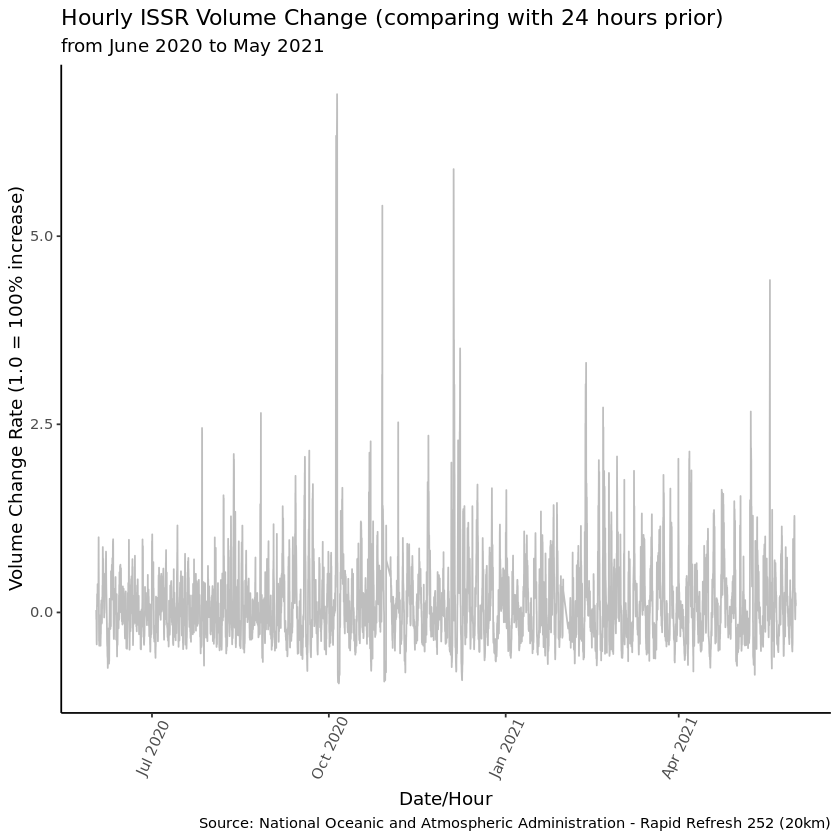

In [23]:
ggplot(df_join, aes(x= dateTime)) + 
  geom_line(aes(y= volChange_24), color= 'gray') +
  labs(title= "Hourly ISSR Volume Change (comparing with 24 hours prior)", 
       subtitle= "from June 2020 to May 2021", 
       caption= "Source: National Oceanic and Atmospheric Administration - Rapid Refresh 252 (20km)",
       x= "Date/Hour",
       y= "Volume Change Rate (1.0 = 100% increase)") +
theme(axis.text.x = element_text(angle= 65, vjust= 0.6))

#############################################################################################################

In [24]:
data_file <- 's3://partly-cloudy-common-area/issrPlanesHourly.csv'
mydata <- read_csv(file = sagemaker$s3$S3Downloader$read_file(data_file,
                                                              sagemaker_session= session),
                   col_names = TRUE)

df1 <- as.data.frame(mydata)
head(df1)

,dateTime,PlanesInISSR_AllLevels,ISSRsHavePlanes_AllLevels
,<dttm>,<dbl>,<dbl>
1,2021-03-30 03:00:00,263,197
2,2020-12-24 11:00:00,2354,1623
3,2021-05-19 17:00:00,601,427
4,2020-10-05 08:00:00,383,370
5,2021-02-04 02:00:00,480,320
6,2021-01-12 21:00:00,717,506


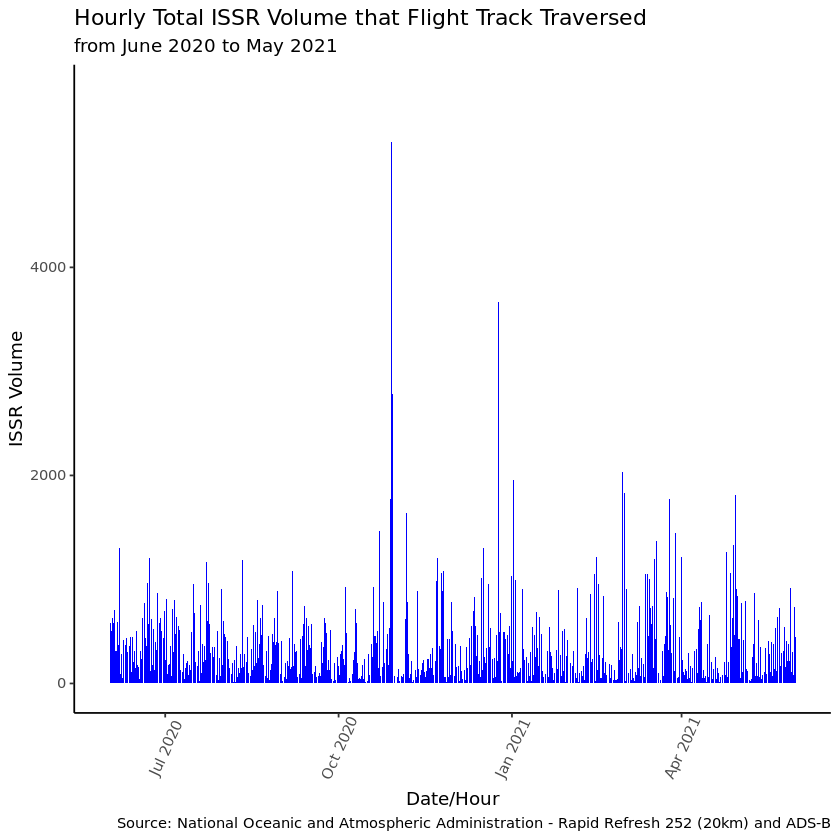

In [25]:
# Plot
g <- ggplot(df1, aes(dateTime, ISSRsHavePlanes_AllLevels))
g + geom_col(fill= "blue") + 
    labs(title= "Hourly Total ISSR Volume that Flight Track Traversed",
         subtitle= "from June 2020 to May 2021",
         caption= "Source: National Oceanic and Atmospheric Administration - Rapid Refresh 252 (20km) and ADS-B",
         x= "Date/Hour", 
         y= "ISSR Volume") +
theme(axis.text.x = element_text(angle=65, vjust=0.6))

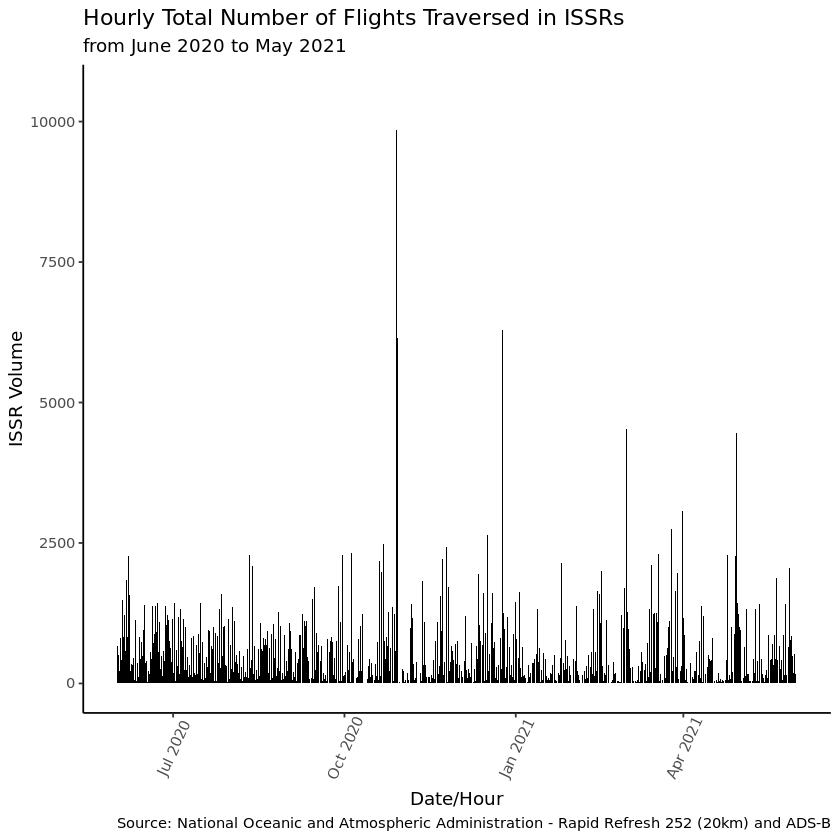

In [26]:
# Plot
g <- ggplot(df1, aes(dateTime, PlanesInISSR_AllLevels))
g + geom_col(fill= "black") + 
    labs(title= "Hourly Total Number of Flights Traversed in ISSRs",
         subtitle= "from June 2020 to May 2021",
         caption= "Source: National Oceanic and Atmospheric Administration - Rapid Refresh 252 (20km) and ADS-B",
         x= "Date/Hour", 
         y= "ISSR Volume") +
theme(axis.text.x = element_text(angle=65, vjust=0.6))

====================================================================================================

In [27]:
data_file <- 's3://partly-cloudy-common-area/dailyPlaneCountsInCenters_comb.csv'
mydata <- read_csv(file = sagemaker$s3$S3Downloader$read_file(data_file,
                                                              sagemaker_session= session),
                   col_names = TRUE)

dailyPlaneCountsInCenters_comb <- as.data.frame(mydata)
dailyPlaneCountsInCenters_comb

IDENT,NAME,numOfTraversedCells,dailyPlanesInCells,TotNumCellsSingleLevel,TotNumCellsAllLevels,percTravesedCells
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ZAB,ALBUQUERQUE,9674,80751,1522,56314,0.17178677
ZAU,CHICAGO,16146,145875,690,25530,0.63243243
ZBW,BOSTON,17499,121149,1070,39590,0.44200556
ZDC,WASHINGTON,12091,147022,796,29452,0.41053239
ZDV,DENVER,13431,100373,1806,66822,0.20099668
ZFW,FORT WORTH,14341,113372,1038,38406,0.37340520
ZHU,HOUSTON,16153,93997,1421,52577,0.30722559
ZID,INDIANAPOLIS,12691,104100,629,23273,0.54531002
ZJX,JACKSONVILLE,15157,110762,1264,46768,0.32408912


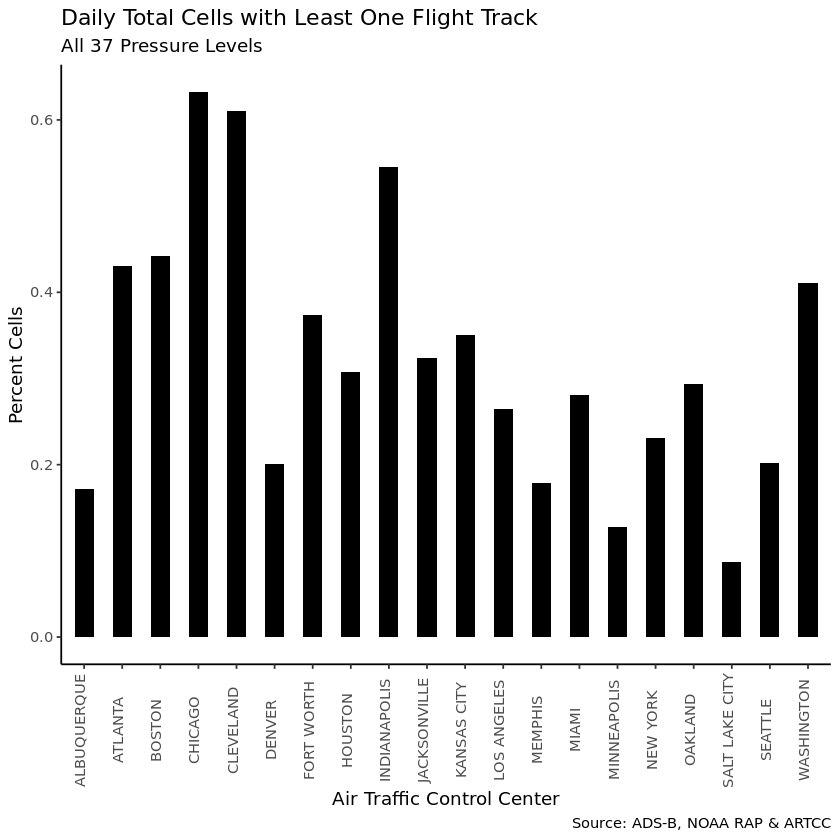

In [28]:
# plot
library(ggplot2)
theme_set(theme_classic())

# Plot
g <- ggplot(dailyPlaneCountsInCenters_comb, aes(NAME, percTravesedCells))
g + geom_bar(stat= "identity", width = 0.5, fill= "black") + 
      labs(title= "Daily Total Cells with Least One Flight Track", 
           subtitle= "All 37 Pressure Levels", 
           caption= "Source: ADS-B, NOAA RAP & ARTCC",
           x= "Air Traffic Control Center",
           y= "Percent Cells") +
      theme(axis.text.x = element_text(angle= 90, vjust= 0.1))

In [29]:
data_file <- 's3://partly-cloudy-common-area/dailyPlaneCountsInCenters_selcomb.csv'
mydata <- read_csv(file = sagemaker$s3$S3Downloader$read_file(data_file,
                                                              sagemaker_session= session),
                   col_names = TRUE)

dailyPlaneCountsInCenters_selcomb <- as.data.frame(mydata)
dailyPlaneCountsInCenters_selcomb

IDENT,NAME,numOfTraversedCells,dailyPlanesInCells,TotNumCellsSingleLevel,TotNumCellsAppLevels,percTravesedCells
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ZAB,ALBUQUERQUE,5821,50109,1522,18264,0.3187144
ZAU,CHICAGO,7753,83042,690,8280,0.9363527
ZBW,BOSTON,9157,62264,1070,12840,0.7131620
ZDC,WASHINGTON,6294,84016,796,9552,0.6589196
ZDV,DENVER,8672,69503,1806,21672,0.4001477
ZFW,FORT WORTH,7756,61587,1038,12456,0.6226718
ZHU,HOUSTON,8716,46467,1421,17052,0.5111424
ZID,INDIANAPOLIS,6849,83576,629,7548,0.9073927
ZJX,JACKSONVILLE,8023,76685,1264,15168,0.5289425


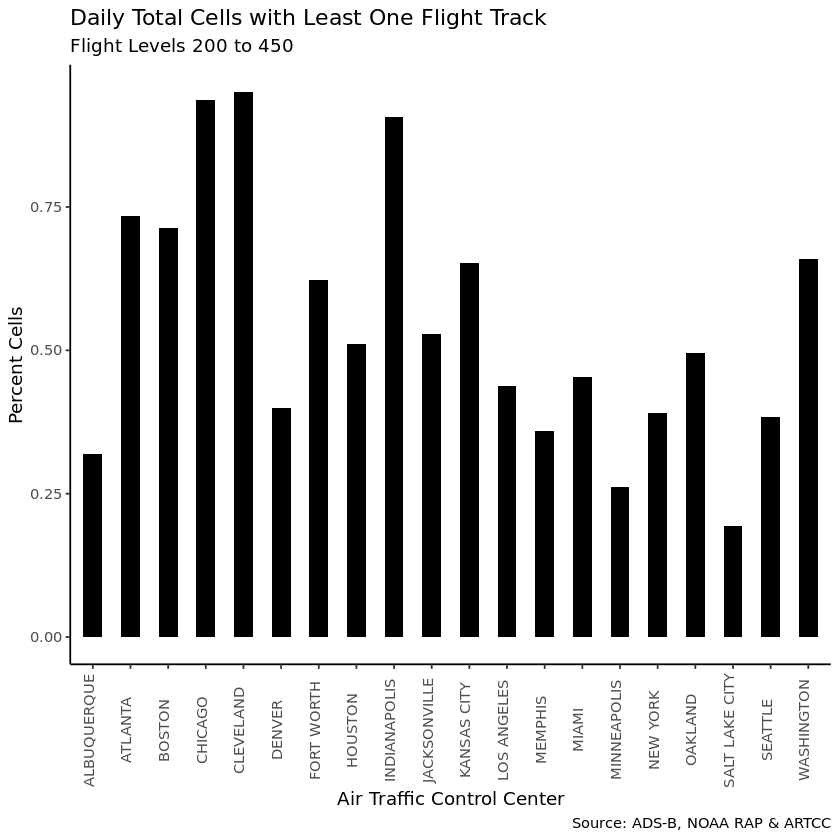

In [30]:
# plot
library(ggplot2)
theme_set(theme_classic())

# Plot
g <- ggplot(dailyPlaneCountsInCenters_selcomb, aes(NAME, percTravesedCells))
g + geom_bar(stat="identity", width= 0.5, fill= "black") + 
      labs(title= "Daily Total Cells with Least One Flight Track", 
           subtitle= "Flight Levels 200 to 450", 
           caption= "Source: ADS-B, NOAA RAP & ARTCC",
           x= "Air Traffic Control Center",
           y= "Percent Cells") +
      theme(axis.text.x = element_text(angle= 90, vjust= 0.1))

====================================================================================================

In [31]:
data_file <- 's3://partly-cloudy-common-area/issrDailyByCenter_pd.csv'
mydata <- read_csv(file = sagemaker$s3$S3Downloader$read_file(data_file,
                                                              sagemaker_session= session),
                   col_names = TRUE)

issrDailyByCenter_pd <- as.data.frame(mydata)
issrDailyByCenter_pd

dateOnly,NAME,iSSRs
<date>,<chr>,<dbl>
2020-12-07,SALT LAKE CITY,3982
2021-04-11,BOSTON,5663
2020-12-17,CLEVELAND,2395
2021-04-26,DENVER,8745
2020-06-09,SALT LAKE CITY,1473
2020-11-08,MEMPHIS,216
2021-05-18,SALT LAKE CITY,2763
2021-01-07,MEMPHIS,3766
2021-04-28,MIAMI,81


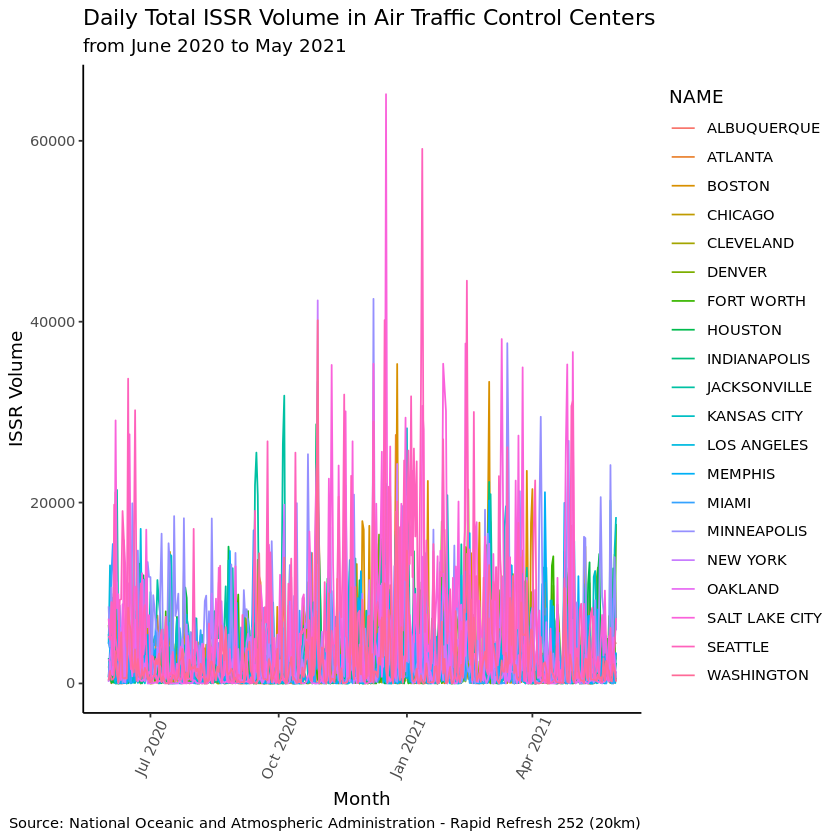

In [32]:
# Plot
g <- ggplot(issrDailyByCenter_pd, aes(dateOnly, iSSRs, colour= NAME))
g + geom_line() + 
    labs(title= "Daily Total ISSR Volume in Air Traffic Control Centers",
         subtitle= "from June 2020 to May 2021",
         caption= "Source: National Oceanic and Atmospheric Administration - Rapid Refresh 252 (20km)",
         x= "Month", 
         y= "ISSR Volume") +
theme(axis.text.x = element_text(angle=65, vjust=0.6))

In [33]:
issrDailyByCenter_pd$mo <- as.integer(strftime(issrDailyByCenter_pd$dateOnly,"%m"))
issrMonthlyByCenter_pd <- issrDailyByCenter_pd %>% group_by(NAME, mo) %>% summarize(iSSRMonth = sum(iSSRs, na.rm= TRUE))
issrMonthlyByCenter_pd

`summarise()` has grouped output by 'NAME'. You can override using the `.groups` argument.



NAME,mo,iSSRMonth
<chr>,<int>,<dbl>
ALBUQUERQUE,1,80184
ALBUQUERQUE,2,59360
ALBUQUERQUE,3,53504
ALBUQUERQUE,4,39143
ALBUQUERQUE,5,40331
ALBUQUERQUE,6,36095
ALBUQUERQUE,7,52456
ALBUQUERQUE,8,28668
ALBUQUERQUE,9,1844


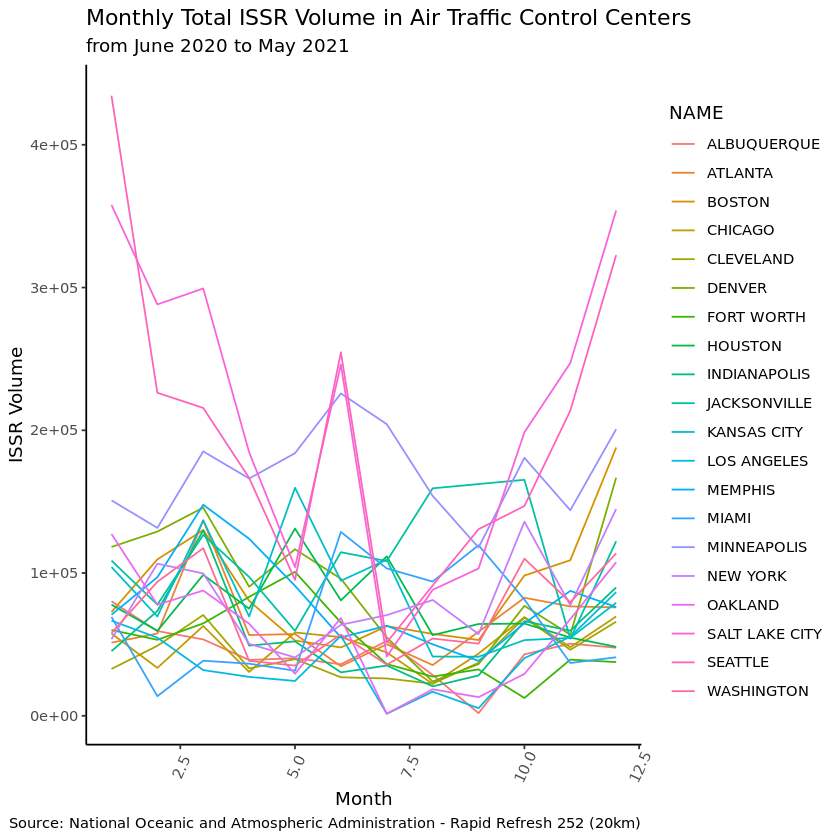

In [34]:
# Plot
g <- ggplot(issrMonthlyByCenter_pd, aes(mo, iSSRMonth, colour= NAME))
g + geom_line() + 
    labs(title= "Monthly Total ISSR Volume in Air Traffic Control Centers",
         subtitle= "from June 2020 to May 2021",
         caption= "Source: National Oceanic and Atmospheric Administration - Rapid Refresh 252 (20km)",
         x= "Month", 
         y= "ISSR Volume") +
theme(axis.text.x = element_text(angle=65, vjust=0.6))

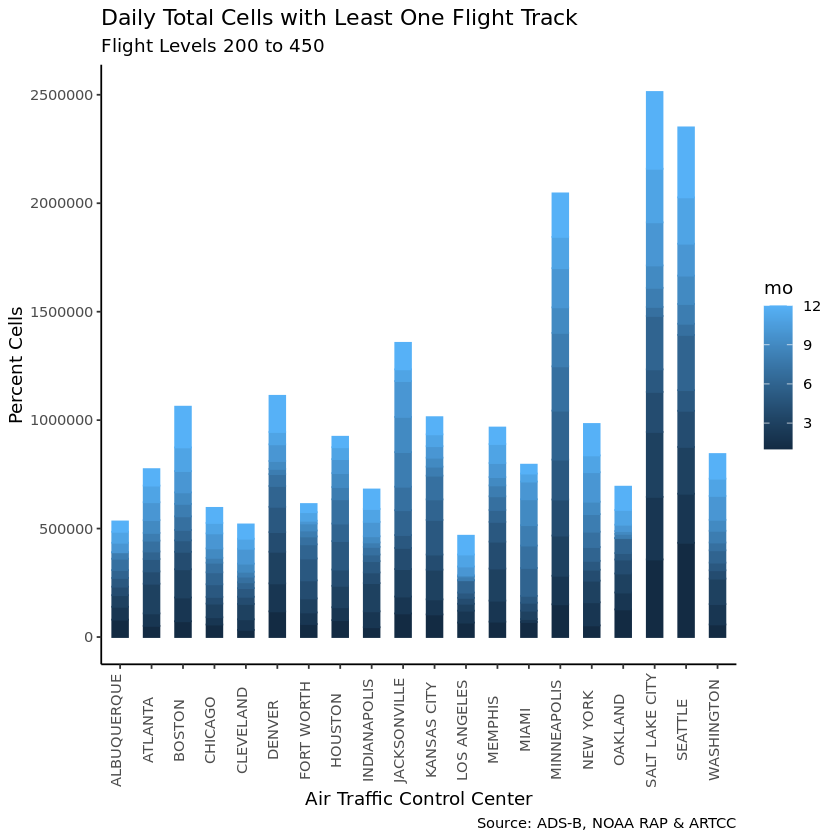

In [35]:
# Plot
g <- ggplot(issrMonthlyByCenter_pd, aes(NAME, iSSRMonth, colour= mo, fill= mo))
g + geom_bar(stat="identity", width= 0.5) + 
      labs(title= "Daily Total Cells with Least One Flight Track", 
           subtitle= "Flight Levels 200 to 450", 
           caption= "Source: ADS-B, NOAA RAP & ARTCC",
           x= "Air Traffic Control Center",
           y= "Percent Cells") +
      theme(axis.text.x = element_text(angle= 90, vjust= 0.1))

=========================================================================================================

In [36]:
library(readr)
data_file <- 's3://partly-cloudy-common-area/proof_of_concept/asdb_conus_rapCell.csv'
asdb_conus_rapCell <- read_csv(file = sagemaker$s3$S3Downloader$read_file(data_file,
                                                              sagemaker_session= session),
                               col_names = TRUE)

In [37]:
asdb_conus_rapCell$cellCenterAlt = (1 - (asdb_conus_rapCell$hPa/1013.25)**0.190284) * 145366.45
asdb_conus_rapCell$fl = round(asdb_conus_rapCell$cellCenterAlt/100, -1)
asdb_conus_rapCell

DateTime,id,Altitude,Latitude,Longitude,hPa,Nx,Ny,distToCellCenter,cellCenterAlt,fl
<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2016-06-20,4196601,2350,36.07640,-115.12766,925,75,98,10.470790,2498.8602,20
2016-06-20,11069170,10675,35.13814,-80.78951,675,230,89,10.045923,10812.7502,110
2016-06-20,10700817,7400,30.63221,-81.58645,775,228,64,7.585762,7228.7280,70
2016-06-20,11281093,1575,40.74247,-73.84017,950,256,124,7.823334,1772.0302,20
2016-06-20,12598340,37000,45.25613,-81.58849,225,220,146,4.413524,36195.4966,360
2016-06-20,11247105,4600,38.48734,-122.86993,850,43,117,2.264978,4779.1936,50
2016-06-20,11327607,2175,28.47210,-81.28140,925,231,52,6.911351,2498.8602,20
2016-06-20,10719488,10075,33.46631,-84.27338,700,214,78,13.141516,9878.3850,100
2016-06-20,11067919,3900,44.80932,-93.26207,875,172,141,5.707495,4001.5907,40


Warning message:
“Removed 4750 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


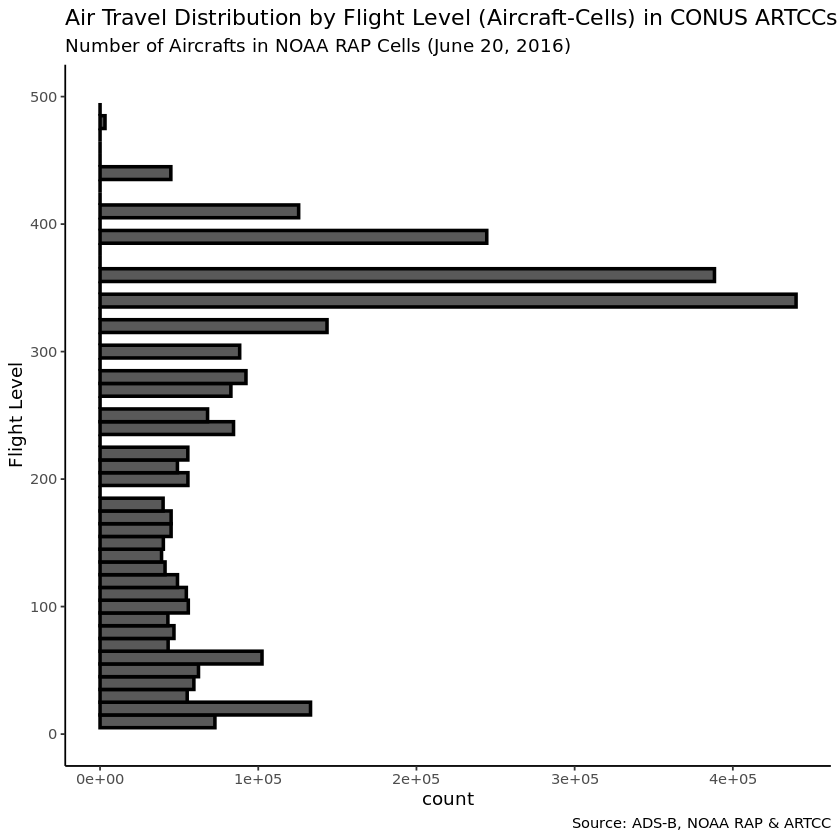

In [38]:
g <- ggplot(asdb_conus_rapCell, aes(fl)) + scale_fill_brewer(palette= "Spectral")
g + geom_histogram(#aes(fill=class), 
                   binwidth = 10, 
                   col= "black", 
                   size= 1) +  coord_flip() + xlim(0, 500) +
  labs(title="Air Travel Distribution by Flight Level (Aircraft-Cells) in CONUS ARTCCs", 
       subtitle="Number of Aircrafts in NOAA RAP Cells (June 20, 2016)",
       x= "Flight Level", 
       caption= "Source: ADS-B, NOAA RAP & ARTCC")  

=========================================================================================================

In [39]:
data_file <- 's3://partly-cloudy-common-area/TotalISSR_CellHours_byFL.csv'
issrByFL <- read_csv(file = sagemaker$s3$S3Downloader$read_file(data_file,
                                                              sagemaker_session= session),
                               col_names = TRUE)

In [40]:
issrByFL

FLevel,iSSRs
<dbl>,<dbl>
210,627523
220,1496040
240,2061436
250,2327308
270,3280095
280,4117030
300,7887379
320,15801622
340,3841063


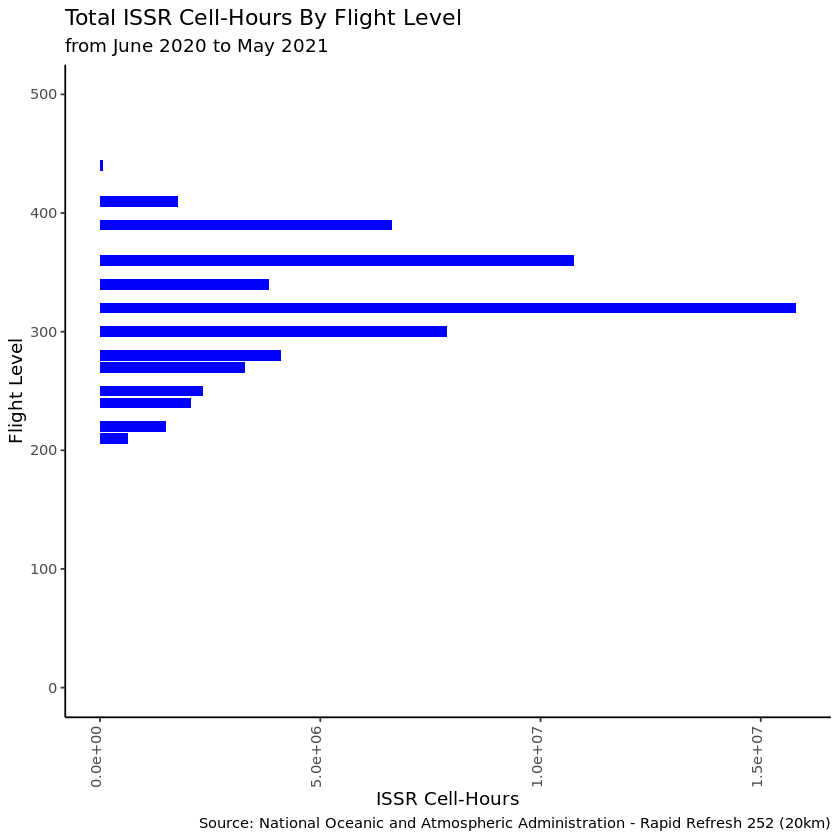

In [41]:
# plot
library(ggplot2)
theme_set(theme_classic())

# Plot
g <- ggplot(issrByFL, aes(FLevel, iSSRs))
g + geom_bar(stat="identity", width= 9, fill= "blue") + coord_flip() + xlim(0, 500) +
      labs(title= "Total ISSR Cell-Hours By Flight Level",
           subtitle= "from June 2020 to May 2021",
           caption= "Source: National Oceanic and Atmospheric Administration - Rapid Refresh 252 (20km)",
           x= "Flight Level",
           y= "ISSR Cell-Hours") +
      theme(axis.text.x = element_text(angle= 90, vjust= 0.1))